EEG 2 ACTIVITIES CLASSIFIER

In [132]:
import numpy as np
import pyedflib

import matplotlib.pyplot as plt
import scipy.signal as sig
from statsmodels.tsa.ar_model import AutoReg
import pandas as pd
import os
from mne.decoding import CSP

from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, recall_score


In [133]:
#filtering with band-pass fir filter
def filter_with_bandpass(S,fs,low_cutoff = 8,high_cutoff = 13,order = 501, plot_filter=False):
    S_filtered = np.copy(S)

    b = sig.firwin(order, [low_cutoff, high_cutoff], fs=fs, pass_zero = False)
    
    for i in range(len(S_filtered)):
        
        S_filtered[i] = sig.lfilter(b,[1],S_filtered[i])


    if plot_filter:
        w,h = sig.freqz(b)
        plt.plot(w * fs / (2 * np.pi), abs(h), 'b')
        plt.title('Band-Pass Filter Frequency Response (8.0 Hz to 13.0 Hz)')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Gain')
        plt.grid(True)
        plt.show()
    
    return S_filtered

In [134]:
#READING THE SIGNALS
def read_edf(rec_num):
    all_data = []
    for num in [3,7,11]:
        rec_name = f"files/S{rec_num:03d}/S{rec_num:03d}R{num:02d}.edf"
        #read edf file 
        edf_file = pyedflib.EdfReader(rec_name)

        #num of signals
        n_signals = edf_file.signals_in_file

        #labels of which signals it is (on the head)
        signal_labels = edf_file.getSignalLabels()
        signal_labels = [label.replace(".", "") for label in signal_labels]

        #sampling freq
        sample_frequency = edf_file.getSampleFrequencies()
        sample_frequency = sample_frequency[0]

        #get annotations on the signal (T0, T1,T2)
        annotations = edf_file.readAnnotations()
        start_event_times = annotations[0]
        
        durations = annotations[1]

        #T0 is the base state, T1 is the imagining of clinching left fist, T2 is the imagining of clinching of right fist
        descriptions = annotations[2]
        
        #all 64 signals
        signals = np.zeros((n_signals, len(edf_file.readSignal(0))))
        for i in range(n_signals):
            signal = edf_file.readSignal(i)
            signals[i] = signal

        signals = filter_with_bandpass(signals, sample_frequency)
        all_data.append([signals,signal_labels,start_event_times, durations, descriptions, sample_frequency])
        edf_file.close()

    return all_data

In [135]:
def read_edf_database():
    all_signals = []
    for i in range(109):
        all_signals.append(read_edf(i))
    return all_signals

In [136]:
def plot_signal_with_annotations_and_state_changes(signals,signal_labels, start_event_times, durations, descriptions, fs, 
                                                   signal_idx="C1", start_time=0, end_time=None,S=False, S_signal_select = 0):
    
    
    if not S:
        signal_idx_index = signal_labels.index(signal_idx)

        # Select the signal to plot
        signal = signals[signal_idx_index]
    else:
        signal = signals[S_signal_select]
        signal_idx  = "S"  + str(S_signal_select + 1)

    # Determine the sample range for the specified time window
    if end_time is None:
        end_time = len(signal) / fs  # Default to the entire signal duration
    start_sample = int(start_time * fs)
    end_sample = int(end_time * fs)

    # Extract the portion of the signal to display
    signal_segment = signal[start_sample:end_sample]
    time_segment = np.linspace(start_time, end_time, len(signal_segment))

    # Filter annotations to match the time window
    filtered_events = [
        (start, dur, desc) for start, dur, desc in zip(start_event_times, durations, descriptions)
        if start >= start_time and start < end_time
    ]

    # Plot the signal
    plt.figure(figsize=(15, 6))
    plt.plot(time_segment, signal_segment, label=f"Signal {signal_idx}", color="blue", linewidth=1)
    plt.title(f"Signal {signal_idx} with Annotations (Time {start_time}s to {end_time}s)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # Plot colored annotation bars and vertical lines for state changes
    color_map = {"T0": "green", "T1": "red", "T2": "orange"}  # Map descriptions to colors
    y_bar_pos = max(signal_segment) + 10  # Position for annotation bars
    prev_description = None  # Keep track of the previous state
    for start, duration, description in filtered_events:
        # Plot annotation bar
        color = color_map.get(description, "black")  # Default to black if description not in color_map
        plt.hlines(y_bar_pos, start, start + duration, colors=color, linewidth=8, label=description if start == filtered_events[0][0] else "")
        plt.text(
            start + duration / 2, y_bar_pos + 5, description, color=color, fontsize=8, ha="center", va="bottom"
        )

        # Plot vertical line for state change
        if description != prev_description:  # State change detected
            plt.axvline(x=start, color="black", linestyle="--", linewidth=1, alpha=0.7, label="State Change" if prev_description is None else "")
        prev_description = description

    # Avoid duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    # Adjust axis limits to accommodate annotations
    
    plt.ylim([min(signal_segment) - 10, y_bar_pos + 10])

    # Show the plot
    plt.show()

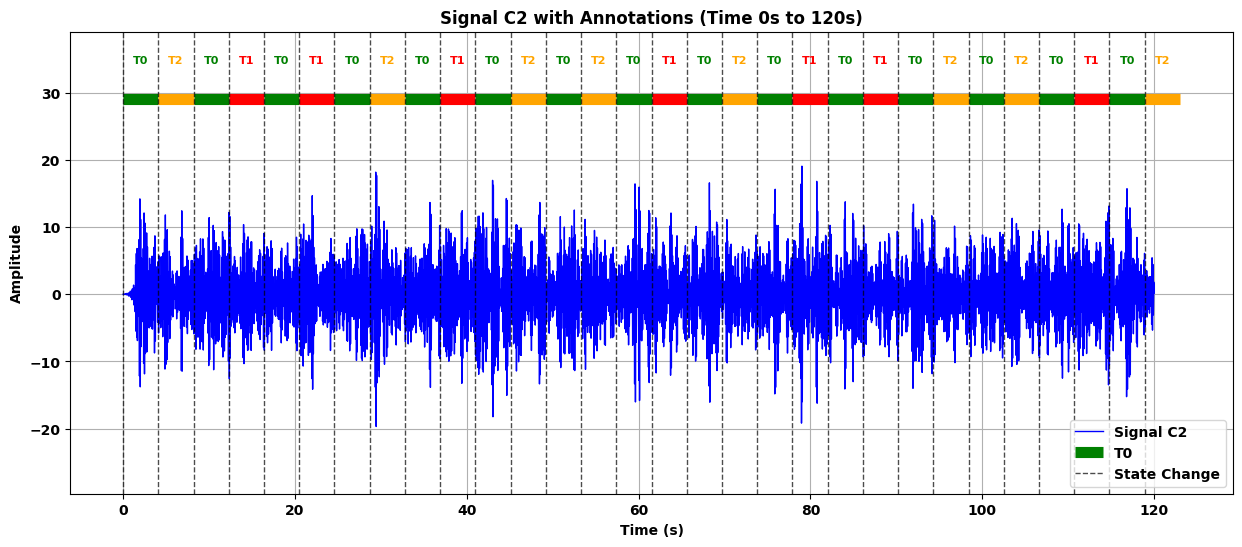

In [137]:
#RO4 files are the files where imagining clinching left and right fist
signals, signal_labels, start_event_times, durations, descriptions, fs = read_edf(4)[1]
plot_signal_with_annotations_and_state_changes(signals,signal_labels, start_event_times, durations, descriptions, fs, "C2", 0,120)

In [138]:
signals, signal_labels, start_event_times, durations, descriptions, fs = read_edf(4)[1]

In [139]:
descriptions

array(['T0', 'T2', 'T0', 'T1', 'T0', 'T1', 'T0', 'T2', 'T0', 'T1', 'T0',
       'T2', 'T0', 'T2', 'T0', 'T1', 'T0', 'T2', 'T0', 'T1', 'T0', 'T1',
       'T0', 'T2', 'T0', 'T2', 'T0', 'T1', 'T0', 'T2'], dtype='<U2')

In [140]:
def get_csp_filter(signals, annot = np.array(["T1", "T2"]), n_components=6):
    csp = CSP(n_components=64, reg=None, log=True)
    csp.fit(signals, annot)
    W = csp.filters_
    return W

In [141]:
first_T1 = list(descriptions).index("T1")
first_T2 = list(descriptions).index("T2")
first_T1_signal = signals[:,int(start_event_times[first_T1]*fs):int(start_event_times[first_T1]*fs)+int(durations[first_T1]*fs)]
first_T2_signal = signals[:,int(start_event_times[first_T2]*fs):int(start_event_times[first_T2]*fs)+int(durations[first_T2]*fs)]
W = get_csp_filter(np.array([first_T1_signal, first_T2_signal]),np.array( ["T1", "T2"]), 6)
S = W @signals

Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 64 dim * 1.1e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=T1 covariance using EMPIRICAL
Done.
Estimating class=T2 covariance using EMPIRICAL
Done.


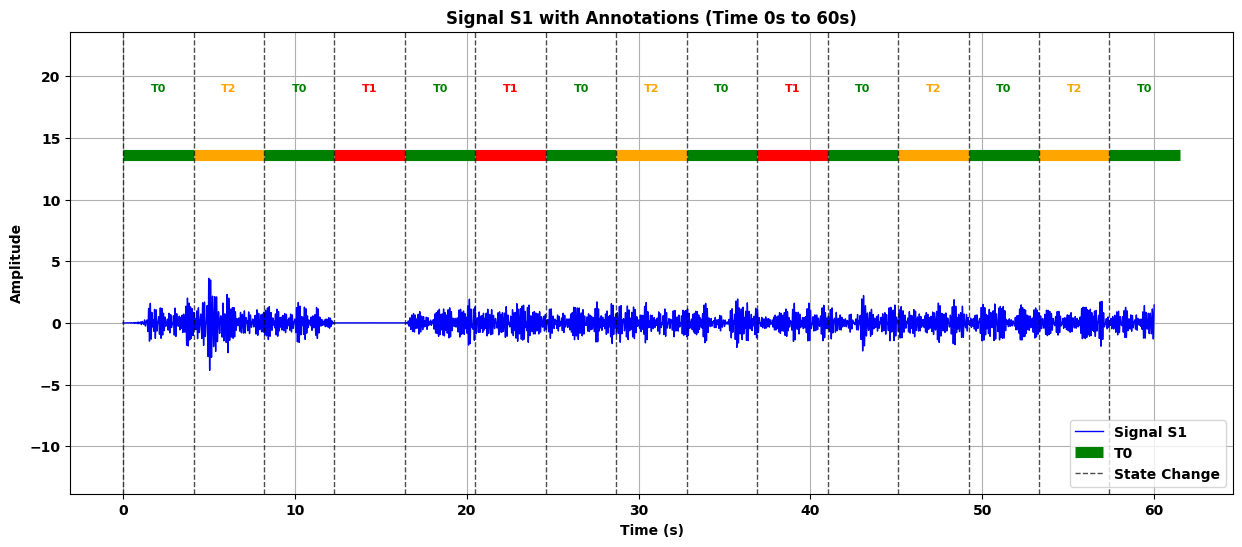

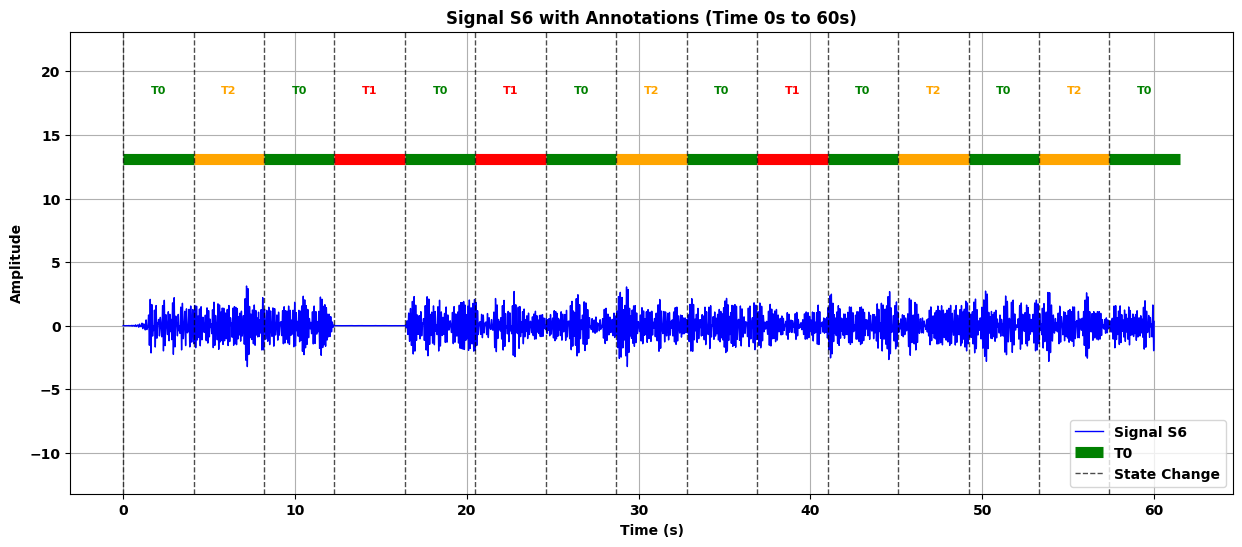

In [142]:
plot_signal_with_annotations_and_state_changes(S, signal_labels, start_event_times, durations, descriptions, fs, S = True, S_signal_select=0, start_time=0, end_time=60)
plot_signal_with_annotations_and_state_changes(S, signal_labels, start_event_times, durations, descriptions, fs, S = True, S_signal_select=5, start_time=0, end_time=60)

In [143]:
def separate_signals_by_class(matrix, start_event_times, durations, descriptions, fs, num = 1):
    #get samples instead of seconds
    start_event_samples = [int(start*fs) for start in start_event_times]
    duration_samples = [int(duration * fs) for duration in durations]

    cnt1 = 0
    cnt2 = 0


    #through all states
    for i in range(len(start_event_samples)):
        #matrix of the current state
        tmp_mtx = np.zeros((64, duration_samples[i]))
        tmp_mtx = matrix[:,start_event_samples[i]:start_event_samples[i] + duration_samples[i]]

        #cases for each state, calculate covariace and add to the avg covaricance matrix
        if descriptions[i] == "T1":
     
            signals_T1 = tmp_mtx


        elif descriptions[i] == "T2":
            signals_T2 = tmp_mtx

        if cnt1 >= num and cnt2 >= num:
            break
    
    return signals_T1, signals_T2

In [145]:
def csp_filtering(signals, start_event_times, durations, descriptions, fs , n):
    first_T1 = list(descriptions).index("T1")
    first_T2 = list(descriptions).index("T2")
    first_T1_signal = signals[:,int(start_event_times[first_T1]*fs):int(start_event_times[first_T1]*fs)+int(durations[first_T1]*fs)]
    first_T2_signal = signals[:,int(start_event_times[first_T2]*fs):int(start_event_times[first_T2]*fs)+int(durations[first_T2]*fs)]
    W = get_csp_filter(np.array([first_T1_signal, first_T2_signal]),np.array( ["T1", "T2"]), 6)
    ind = 4
    return S, W, ind

In [146]:
S,W, ind = csp_filtering(signals, start_event_times, durations,descriptions, fs, 4)
W.shape

Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 64 dim * 1.1e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=T1 covariance using EMPIRICAL
Done.
Estimating class=T2 covariance using EMPIRICAL
Done.


(64, 64)

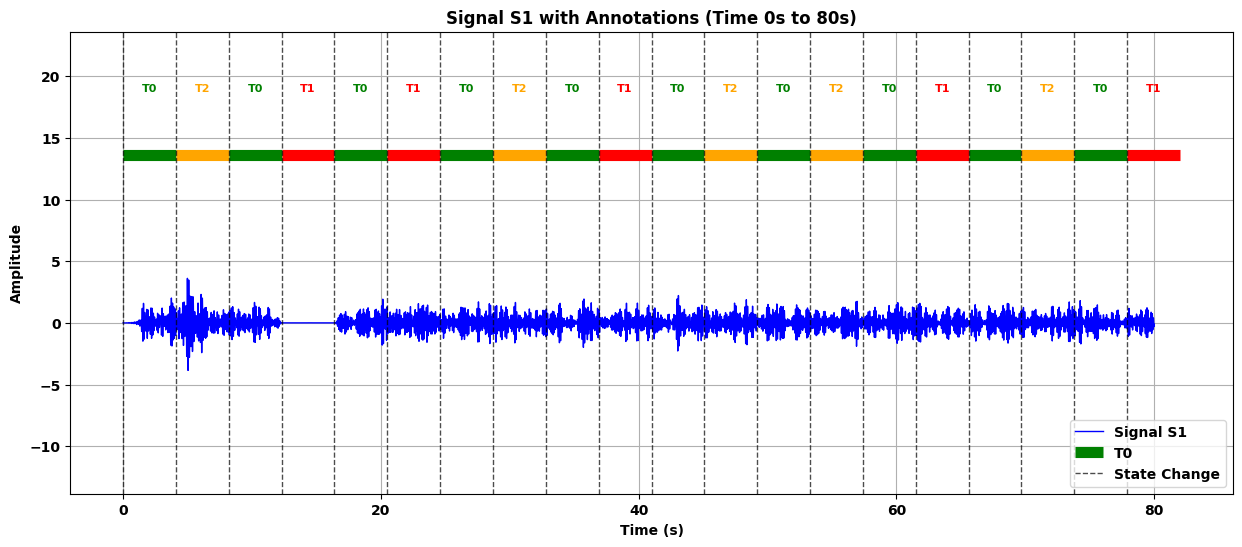

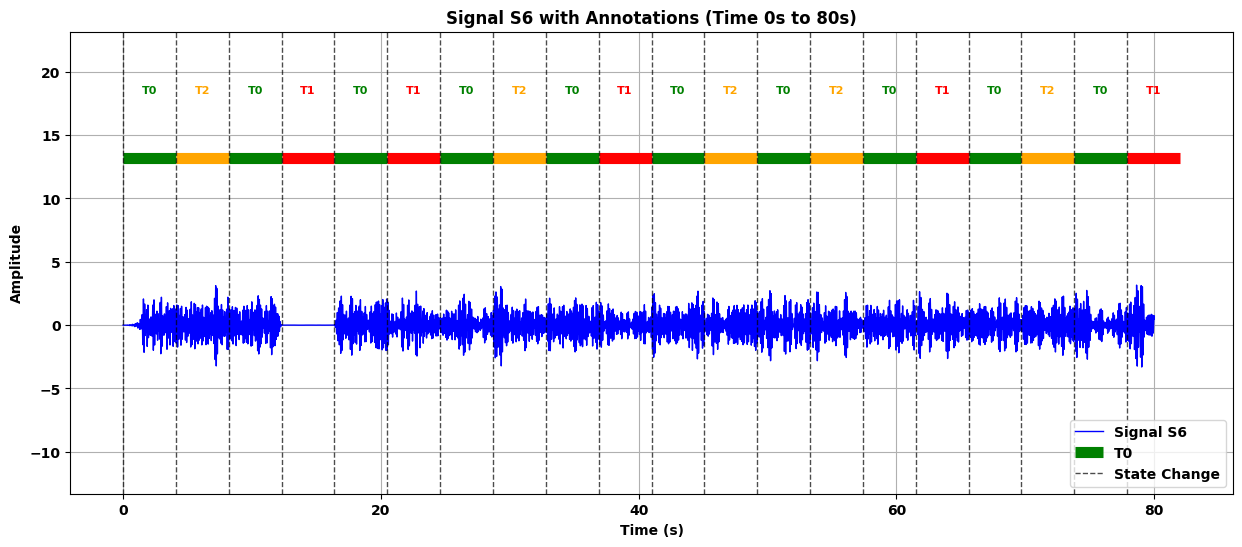

In [148]:
plot_signal_with_annotations_and_state_changes(S, signal_labels, start_event_times, durations, descriptions, fs, S = True, S_signal_select=0, start_time=0, end_time=80)
plot_signal_with_annotations_and_state_changes(S, signal_labels, start_event_times, durations, descriptions, fs, S = True, S_signal_select=5, start_time=0, end_time=80)

In [11]:
def get_features(S, start_event_times, durations, descriptions,fs, p = 10):

    #get samples instead of seconds
    start_event_samples = [int(start*fs) for start in start_event_times]
    duration_samples = [int(duration * fs) for duration in durations]

    features = []

    #through all states
    for i in range(len(start_event_samples)):
        tmp = []
        
        #cases for each state, calculate covariace and add to the avg covaricance matrix
        if descriptions[i] == "T1":

            for signal in S:
                
                tmp.append(np.log(np.var(signal[start_event_samples[i]:start_event_samples[i] + duration_samples[i]])))
                model = AutoReg(signal[start_event_samples[i]:start_event_samples[i] + duration_samples[i]], p)
                model_fitted = model.fit()
                # AR parameters (coefficients)
                ar_params = model_fitted.params  # Exclude the constant term
                tmp.extend(ar_params)
            tmp.append("T1")
            features.append(tmp)
            

        elif descriptions[i] == "T2":
            
            for signal in S:
                tmp.append(np.log(np.var(signal[start_event_samples[i]:start_event_samples[i] + duration_samples[i]])))
                model = AutoReg(signal[start_event_samples[i]:start_event_samples[i] + duration_samples[i]], p)
                model_fitted = model.fit()
                # AR parameters (coefficients)
                ar_params = model_fitted.params
                tmp.extend(ar_params)
            tmp.append("T2")
            features.append(tmp)
        

    return features

In [13]:
sensitivities = {
                "LDA" : [],
        "QDA" : [],
        "Random Forest": [],
        "XGBOOST" :[],
        "Logistic regression": [],
        "Decision trees": [],
        "Support vector machines":  [],
        "Naive Bayes":  [],
        "MLP": []
    }

specificities = {
                "LDA" : [],
        "QDA" : [],
        "Random Forest": [],
        "XGBOOST" :[],
        "Logistic regression": [],
        "Decision trees": [],
        "Support vector machines":  [],
        "Naive Bayes":  [],
        "MLP": []
    }
results_lengths = []

for j in range(1,10):    
    #read for one person
    all_signals = read_edf(j)

    for i,signal in enumerate(all_signals):
        if i == 0:
            S, W, ind = csp_filtering(signal[0],signal[2], signal[3],signal[4],signal[5], 3, num=1)
        else:
            S = W @ signal[0]
            

        #S_filtered = filter_with_bandpass(S, signal[5])
        S_filtered = S


        features = get_features(S_filtered, signal[2], signal[3], signal[4], signal[5],p =10)


        if i == 0:
            df = pd.DataFrame(features)
        
        else:
            df_new =  pd.DataFrame(features)

            df = pd.concat([df,df_new], ignore_index=True)

        
    X = df.drop(len(df.columns)-1, axis=1)
    y = df[len(df.columns)-1]

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    #shuffle false because its time series
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, shuffle=False)

    scaler  = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)



    models = {
        "LDA" : LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'),
        "QDA" : QuadraticDiscriminantAnalysis(),
        "Random Forest": RandomForestClassifier(random_state=42),
        "XGBOOST" : XGBClassifier(eval_metric='logloss'),
        "Logistic regression": LogisticRegression(),
        "Decision trees": DecisionTreeClassifier(),
        "Support vector machines": SVC(),
        "Naive Bayes": GaussianNB(),
        "MLP": MLPClassifier(max_iter=500)
        
    }
    print(f"for {j}")

    for key,value in models.items():
        clf = value
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        # Sensitivity 
        sensitivity = tp / (tp + fn)
        sensitivities[key].append(sensitivity)

        # Specificity
        specificity = tn / (tn + fp)
        specificities[key].append(specificity)
        
        #print(f"For {key} the Sensitivity is: {sensitivity:.2f}")
        #print(f"For {key} the Specificity is: {specificity:.2f}")
    

    results_lengths.append(len(df))

for key in sensitivities.keys():
    print(f"avg sensitivity for {key} is {np.mean(sensitivities[key])}")
    print(f"avg specificity for {key} is {np.mean(specificities[key])} ")

    

Computing rank from data with rank=None
    Using tolerance 44 (2.2e-16 eps * 64 dim * 3.1e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=T1 covariance using EMPIRICAL
Done.
Estimating class=T2 covariance using EMPIRICAL
Done.
for 1


c:\Users\marko\Desktop\biomedical_signal_processing\Classifying-eeg-signal\eeg\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\marko\Desktop\biomedical_signal_processing\Classifying-eeg-signal\eeg\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 64 dim * 1.9e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=T1 covariance using EMPIRICAL
Done.
Estimating class=T2 covariance using EMPIRICAL
Done.
for 2


c:\Users\marko\Desktop\biomedical_signal_processing\Classifying-eeg-signal\eeg\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\marko\Desktop\biomedical_signal_processing\Classifying-eeg-signal\eeg\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Computing rank from data with rank=None
    Using tolerance 42 (2.2e-16 eps * 64 dim * 3e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=T1 covariance using EMPIRICAL
Done.
Estimating class=T2 covariance using EMPIRICAL
Done.
for 3


c:\Users\marko\Desktop\biomedical_signal_processing\Classifying-eeg-signal\eeg\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\marko\Desktop\biomedical_signal_processing\Classifying-eeg-signal\eeg\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Computing rank from data with rank=None
    Using tolerance 26 (2.2e-16 eps * 64 dim * 1.8e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=T1 covariance using EMPIRICAL
Done.
Estimating class=T2 covariance using EMPIRICAL
Done.
for 4


c:\Users\marko\Desktop\biomedical_signal_processing\Classifying-eeg-signal\eeg\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\marko\Desktop\biomedical_signal_processing\Classifying-eeg-signal\eeg\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 64 dim * 1.1e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=T1 covariance using EMPIRICAL
Done.
Estimating class=T2 covariance using EMPIRICAL
Done.
for 5


c:\Users\marko\Desktop\biomedical_signal_processing\Classifying-eeg-signal\eeg\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\marko\Desktop\biomedical_signal_processing\Classifying-eeg-signal\eeg\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 64 dim * 9.1e+14  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=T1 covariance using EMPIRICAL
Done.
Estimating class=T2 covariance using EMPIRICAL
Done.
for 6


c:\Users\marko\Desktop\biomedical_signal_processing\Classifying-eeg-signal\eeg\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\marko\Desktop\biomedical_signal_processing\Classifying-eeg-signal\eeg\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Computing rank from data with rank=None
    Using tolerance 41 (2.2e-16 eps * 64 dim * 2.9e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=T1 covariance using EMPIRICAL
Done.
Estimating class=T2 covariance using EMPIRICAL
Done.
for 7


c:\Users\marko\Desktop\biomedical_signal_processing\Classifying-eeg-signal\eeg\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\marko\Desktop\biomedical_signal_processing\Classifying-eeg-signal\eeg\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 64 dim * 1.6e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=T1 covariance using EMPIRICAL
Done.
Estimating class=T2 covariance using EMPIRICAL
Done.
for 8


c:\Users\marko\Desktop\biomedical_signal_processing\Classifying-eeg-signal\eeg\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\marko\Desktop\biomedical_signal_processing\Classifying-eeg-signal\eeg\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Computing rank from data with rank=None
    Using tolerance 36 (2.2e-16 eps * 64 dim * 2.5e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=T1 covariance using EMPIRICAL
Done.
Estimating class=T2 covariance using EMPIRICAL
Done.
for 9


c:\Users\marko\Desktop\biomedical_signal_processing\Classifying-eeg-signal\eeg\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\marko\Desktop\biomedical_signal_processing\Classifying-eeg-signal\eeg\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


avg sensitivity for LDA is 0.5748122248122248
avg specificity for LDA is 0.4970473970473971 
avg sensitivity for QDA is 0.4868427868427868
avg specificity for QDA is 0.5036260036260036 
avg sensitivity for Random Forest is 0.5411421911421912
avg specificity for Random Forest is 0.4760942760942761 
avg sensitivity for XGBOOST is 0.5270784770784771
avg specificity for XGBOOST is 0.4372830872830873 
avg sensitivity for Logistic regression is 0.6035612535612535
avg specificity for Logistic regression is 0.4970473970473971 
avg sensitivity for Decision trees is 0.5179875679875681
avg specificity for Decision trees is 0.5750971250971252 
avg sensitivity for Support vector machines is 0.6464646464646464
avg specificity for Support vector machines is 0.3425925925925926 
avg sensitivity for Naive Bayes is 0.5755374255374256
avg specificity for Naive Bayes is 0.4095959595959596 
avg sensitivity for MLP is 0.5826469826469826
avg specificity for MLP is 0.5303936803936804 
